# DeepSeedlings: Vectorize Images
Using pre-trained Tensorflow CNNs (with the last layer 'cut' off) to vectorize images.

In [1]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import seaborn as sns
import keras
from keras import backend as K
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from tqdm import tqdm
import pickle

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Preprocessing

In [2]:
from keras.applications import vgg16, vgg19, inception_v3, resnet50, xception
from keras.models import Model

In [3]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [4]:
SAMPLE_PER_CATEGORY = 200
SEED = 1987
data_dir = '/home/ubuntu/.kaggle/competitions/plant-seedlings-classification'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [5]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [6]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.head(2)

,file,category_id,category
0,train/Black-grass/765a69082.png,0,Black-grass
1,train/Black-grass/b790f7be5.png,0,Black-grass


In [7]:
train.shape

(4750, 3)

In [8]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.head(2)

,file,category_id,category
0,train/Common wheat/585041992.png,4,Common wheat
1,train/Sugar beet/d5d909ed5.png,11,Sugar beet


In [9]:
train.shape

(2400, 3)

In [10]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head(2)

,filepath,file
0,test/5bdcfa329.png,5bdcfa329.png
1,test/3d67c434b.png,3d67c434b.png


In [11]:
test.shape

(794, 2)

In [12]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

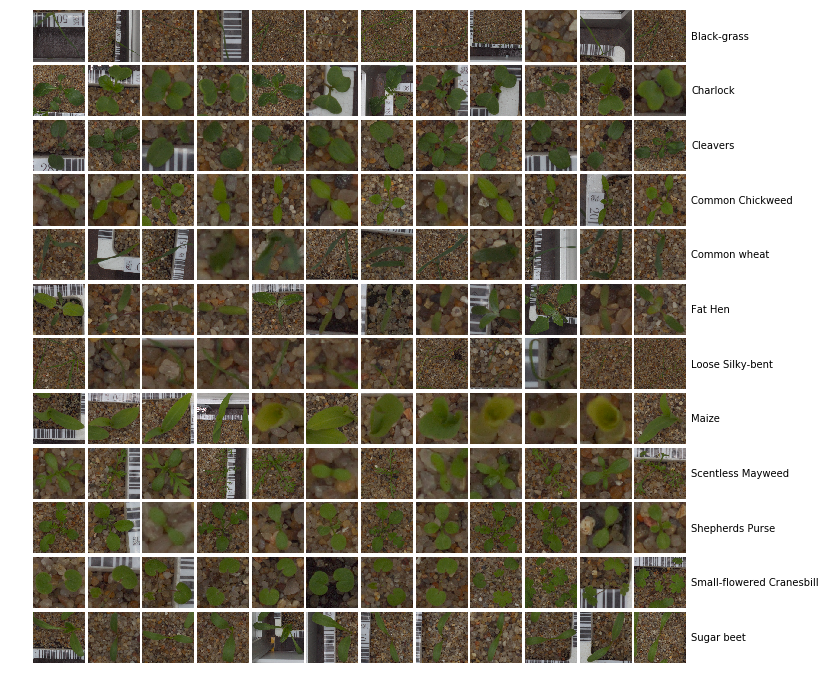

In [13]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

In [ ]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(train))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

In [18]:
pickle.dump(ytr, open('ytr.p','wb'))
pickle.dump(yv, open('yv.p','wb'))

## Xception Vectors

In [15]:
INPUT_SIZE = 299
POOLING = 'max'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in tqdm(enumerate(train['file'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

2400it [00:29, 82.25it/s]

Train Images shape: (2400, 299, 299, 3) size: 643,687,200


In [16]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1899, 299, 299, 3), (501, 299, 299, 3), (1899,), (501,))
501/501 [==============================] - 344s 687ms/step
Xception train bottleneck features shape: (1899, 2048) size: 3,889,152
Xception valid bottleneck features shape: (501, 2048) size: 1,026,048


In [17]:
pickle.dump(train_x_bf, open('train_x_bf.p','wb'))
pickle.dump(valid_x_bf, open('valid_x_bf.p', 'wb'))

## InceptionV3 Vectors

In [26]:
INPUT_SIZE = 299
POOLING = 'max'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in tqdm(enumerate(train['file'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    x = inception_v3.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

2400it [00:29, 81.05it/s]

Train Images shape: (2400, 299, 299, 3) size: 643,687,200


In [ ]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
inception_v3_bottleneck = inception_v3.InceptionV3(weights = 'imagenet',include_top=False, pooling=POOLING)

In [ ]:
train_x_inc = inception_v3_bottleneck.predict(Xtr, batch_size = 32, verbose = 1)
valid_x_inc = inception_v3_bottleneck.predict(Xv, batch_size = 32, verbose = 1)

In [ ]:
pickle.dump(train_x_inc, open('train_x_bf.p','wb'))
pickle.dump(valid_x_inc, open('valid_x_bf.p', 'wb'))

## vgg19 Vectors

In [ ]:
INPUT_SIZE = 299
POOLING = 'max'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in tqdm(enumerate(train['file'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    x = vgg19.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

In [ ]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
inception_v3_bottleneck = inception_v3.InceptionV3(weights = 'imagenet',include_top=False, pooling=POOLING)

In [ ]:
def vectorize(model, INPUT_SIZE, POOLING):
    x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
    for i, file in tqdm(enumerate(train['file'])):
        img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
        x = vgg19.preprocess_input(np.expand_dims(img.copy(), axis=0))
        x_train[i] = x
    print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))
    